In [351]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import uniform

import xgboost as xgb

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, LearningCurveDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)


sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

### Import dataset and split data into training and testing sets (80/20)

In [352]:
match_dataset = pd.read_csv("../data/match_dataset.csv")

In [354]:
feature_columns = [col for col in match_dataset.columns 
                   if col not in ['winner', 't1_id', 't2_id', 'match_date', 'event_id']]

X = match_dataset[feature_columns]
y = match_dataset['winner']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTesting set class distribution:")
print(y_test.value_counts())

Training set size: 2303 samples
Testing set size: 576 samples

Training set class distribution:
winner
0    1253
1    1050
Name: count, dtype: int64

Testing set class distribution:
winner
0    313
1    263
Name: count, dtype: int64


In [355]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

### Model 1: Neural Network (MLPClassifier)

In [356]:
param_dist = {
    'hidden_layer_sizes': [
        (256, 128, 64, 32),
        (200, 100, 50, 25),
        (128, 96, 64, 32),
        (150, 100, 50, 25),
        (128, 96, 6, 32),
        (96, 32, 64, 12),
        (256, 12, 96, 128),
        (160, 96, 12, 64),
        (256, 96, 64),
        (128, 96, 32),
        (128, 64, 32),
        (128, 6, 64),
        (64, 32),
        (100, 50),
        (128,),
        (256,),
    ],
    'activation': ['tanh', 'relu'],
    'alpha': uniform(0.0001, 0.1),
    'learning_rate_init': uniform(0.001, 0.1),
}

mlp = MLPClassifier(solver='adam', max_iter=1000, random_state=42)

nn_model = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_dist,
    n_iter=500,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)

In [357]:
nn_model.fit(X_train_normalized, y_train)

y_pred_nn_train = nn_model.predict(X_train_normalized)
y_pred_nn_test = nn_model.predict(X_test_normalized)
y_pred_proba_nn = nn_model.predict_proba(X_test_normalized)[:, 1]

print(f"\nNeural Network Training Complete")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits

Neural Network Training Complete


In [349]:
print(nn_model.best_params_)

{'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (150, 100, 50, 25), 'learning_rate_init': 0.005}


In [350]:
nn_train_acc = accuracy_score(y_train, y_pred_nn_train)
nn_test_acc = accuracy_score(y_test, y_pred_nn_test)
nn_precision = precision_score(y_test, y_pred_nn_test)
nn_recall = recall_score(y_test, y_pred_nn_test)
nn_f1 = f1_score(y_test, y_pred_nn_test)
nn_roc_auc = roc_auc_score(y_test, y_pred_proba_nn)

# display = LearningCurveDisplay.from_estimator(
#     mlp,
#     X_train_normalized,
#     y_train,
#     cv=5,
#     scoring='accuracy',
#     n_jobs=4
# )

# plt.show()

print(f"\nTraining Accuracy: {nn_train_acc:.4f}")
print(f"Testing Accuracy:  {nn_test_acc:.4f}")
print(f"Precision:         {nn_precision:.4f}")
print(f"Recall:            {nn_recall:.4f}")
print(f"F1-Score:          {nn_f1:.4f}")
print(f"ROC-AUC:           {nn_roc_auc:.4f}")


Training Accuracy: 0.9909
Testing Accuracy:  0.8160
Precision:         0.8153
Recall:            0.7719
F1-Score:          0.7930
ROC-AUC:           0.8539


### Model 2: Random Forest

Ensemble of decision trees for robust predictions.

In [188]:
# Train Random Forest
print("Training Random Forest...")
print("=" * 60)

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Train the model
rf_model.fit(X_train_normalized, y_train)

# Make predictions
y_pred_rf_train = rf_model.predict(X_train_normalized)
y_pred_rf_test = rf_model.predict(X_test_normalized)
y_pred_proba_rf = rf_model.predict_proba(X_test_normalized)[:, 1]

# Calculate metrics
rf_train_acc = accuracy_score(y_train, y_pred_rf_train)
rf_test_acc = accuracy_score(y_test, y_pred_rf_test)
rf_precision = precision_score(y_test, y_pred_rf_test)
rf_recall = recall_score(y_test, y_pred_rf_test)
rf_f1 = f1_score(y_test, y_pred_rf_test)
rf_roc_auc = roc_auc_score(y_test, y_pred_proba_rf)

print(f"\n✅ Random Forest Training Complete!")
print(f"\nTraining Accuracy: {rf_train_acc:.4f}")
print(f"Testing Accuracy:  {rf_test_acc:.4f}")
print(f"Precision:         {rf_precision:.4f}")
print(f"Recall:            {rf_recall:.4f}")
print(f"F1-Score:          {rf_f1:.4f}")
print(f"ROC-AUC:           {rf_roc_auc:.4f}")
print(f"\nNumber of trees: {rf_model.n_estimators}")

Training Random Forest...

✅ Random Forest Training Complete!

Training Accuracy: 0.9614
Testing Accuracy:  0.8663
Precision:         0.8394
Recall:            0.8745
F1-Score:          0.8566
ROC-AUC:           0.8770

Number of trees: 200


### Model 3: XGBoost

Gradient boosting algorithm optimized for performance.

In [189]:
# Train XGBoost
print("Training XGBoost...")
print("=" * 60)

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    use_label_encoder=False
)

# Train the model with early stopping
xgb_model.fit(
    X_train_normalized, y_train,
    eval_set=[(X_test_normalized, y_test)],
    verbose=False
)

# Make predictions
y_pred_xgb_train = xgb_model.predict(X_train_normalized)
y_pred_xgb_test = xgb_model.predict(X_test_normalized)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_normalized)[:, 1]

# Calculate metrics
xgb_train_acc = accuracy_score(y_train, y_pred_xgb_train)
xgb_test_acc = accuracy_score(y_test, y_pred_xgb_test)
xgb_precision = precision_score(y_test, y_pred_xgb_test)
xgb_recall = recall_score(y_test, y_pred_xgb_test)
xgb_f1 = f1_score(y_test, y_pred_xgb_test)
xgb_roc_auc = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"\n✅ XGBoost Training Complete!")
print(f"\nTraining Accuracy: {xgb_train_acc:.4f}")
print(f"Testing Accuracy:  {xgb_test_acc:.4f}")
print(f"Precision:         {xgb_precision:.4f}")
print(f"Recall:            {xgb_recall:.4f}")
print(f"F1-Score:          {xgb_f1:.4f}")
print(f"ROC-AUC:           {xgb_roc_auc:.4f}")

Training XGBoost...

✅ XGBoost Training Complete!

Training Accuracy: 1.0000
Testing Accuracy:  0.8542
Precision:         0.8327
Recall:            0.8517
F1-Score:          0.8421
ROC-AUC:           0.8706


### Model Comparison Summary

Compare all three models side by side.

In [190]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Neural Network', 'Random Forest', 'XGBoost'],
    'Train Accuracy': [nn_train_acc, rf_train_acc, xgb_train_acc],
    'Test Accuracy': [nn_test_acc, rf_test_acc, xgb_test_acc],
    'Precision': [nn_precision, rf_precision, xgb_precision],
    'Recall': [nn_recall, rf_recall, xgb_recall],
    'F1-Score': [nn_f1, rf_f1, xgb_f1],
    'ROC-AUC': [nn_roc_auc, rf_roc_auc, xgb_roc_auc]
})

print("\n" + "=" * 100)
print("MODEL COMPARISON SUMMARY")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("=" * 100)

# Find best model by test accuracy
best_idx = comparison_df['Test Accuracy'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_test_acc = comparison_df.loc[best_idx, 'Test Accuracy']

print(f"\n🏆 Best Model: {best_model_name} (Test Accuracy: {best_test_acc:.4f})")


MODEL COMPARISON SUMMARY
         Model  Train Accuracy  Test Accuracy  Precision   Recall  F1-Score  ROC-AUC
Neural Network        0.828485       0.838542   0.832031 0.809886  0.820809 0.872618
 Random Forest        0.961355       0.866319   0.839416 0.874525  0.856611 0.877039
       XGBoost        1.000000       0.854167   0.832714 0.851711  0.842105 0.870643

🏆 Best Model: Random Forest (Test Accuracy: 0.8663)


### Model Performance Visualizations

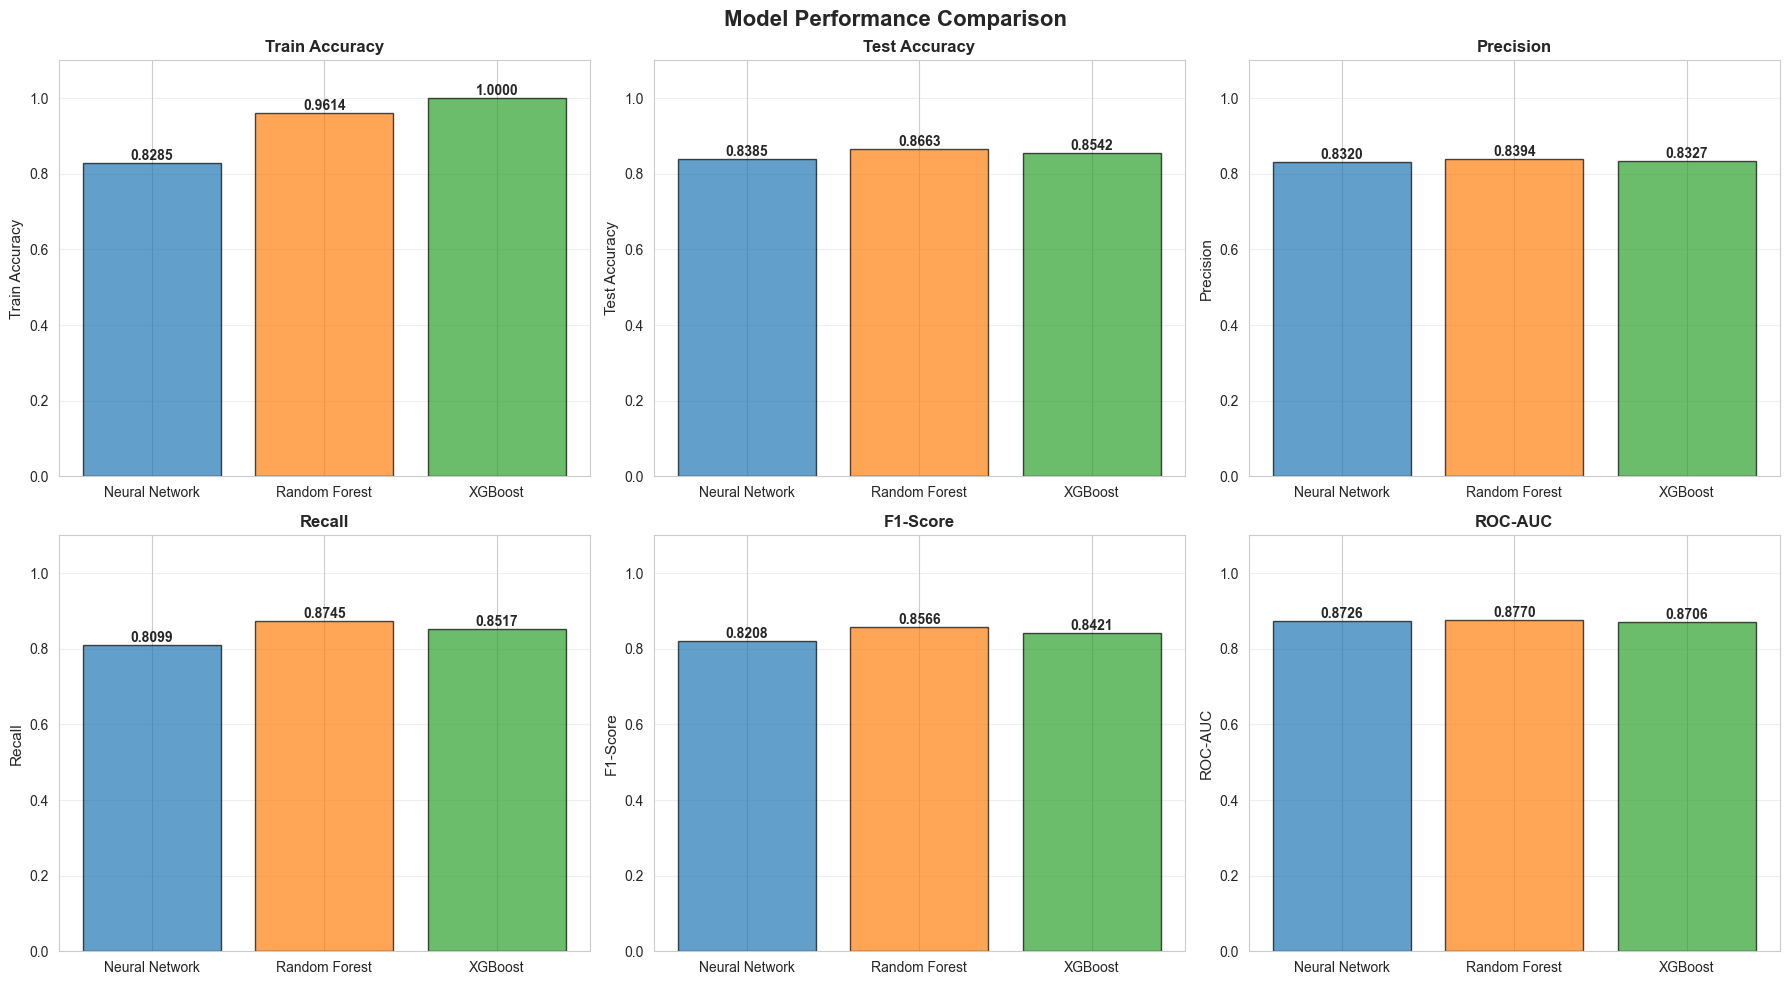

In [191]:
# Create comparison bar plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, metric in enumerate(metrics):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    values = comparison_df[metric].values
    bars = ax.bar(comparison_df['Model'], values, color=colors, alpha=0.7, edgecolor='black')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1.1])
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(comparison_df['Model'], rotation=0, ha='center')

plt.tight_layout()
plt.show()

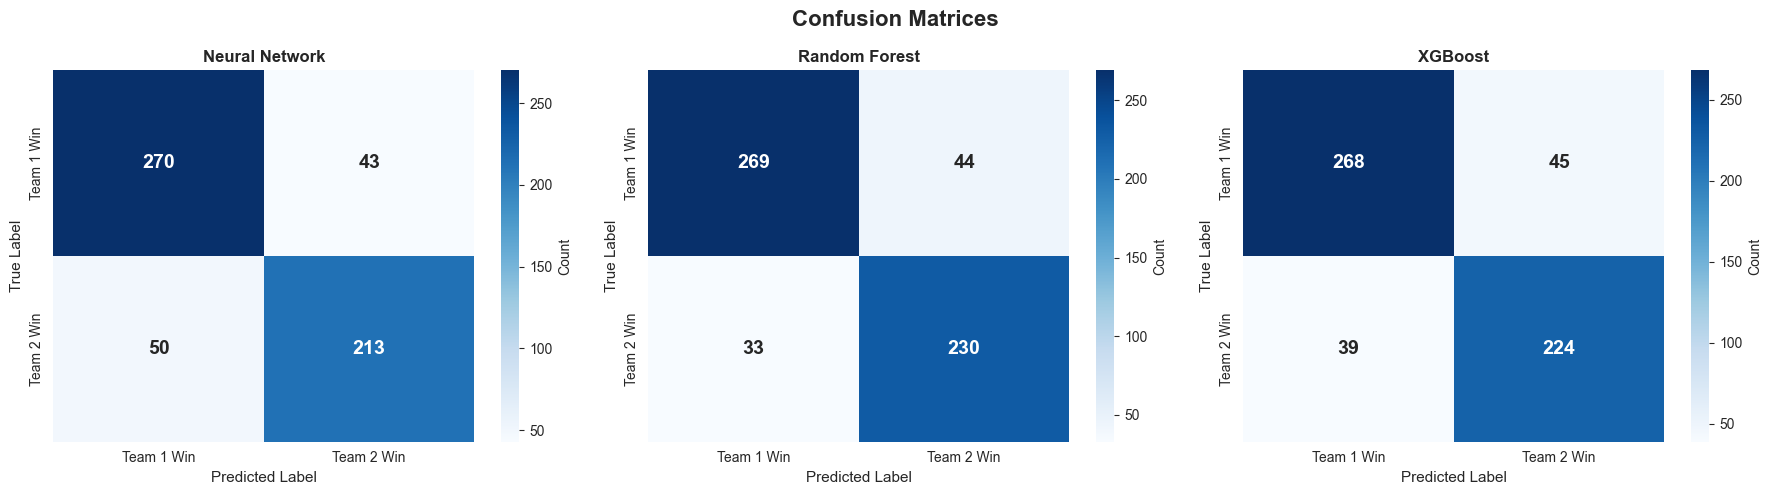


Confusion Matrix Interpretation:
  - Top-left: True Negatives (correctly predicted Team 1 wins)
  - Top-right: False Positives (incorrectly predicted Team 2 wins)
  - Bottom-left: False Negatives (incorrectly predicted Team 1 wins)
  - Bottom-right: True Positives (correctly predicted Team 2 wins)


In [192]:
# Create confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices', fontsize=16, fontweight='bold')

models_data = [
    ('Neural Network', y_pred_nn_test),
    ('Random Forest', y_pred_rf_test),
    ('XGBoost', y_pred_xgb_test)
]

for idx, (name, y_pred) in enumerate(models_data):
    cm = confusion_matrix(y_test, y_pred)
    
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                cbar_kws={'label': 'Count'},
                annot_kws={'size': 14, 'weight': 'bold'})
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=11)
    ax.set_xlabel('Predicted Label', fontsize=11)
    ax.set_xticklabels(['Team 1 Win', 'Team 2 Win'])
    ax.set_yticklabels(['Team 1 Win', 'Team 2 Win'])

plt.tight_layout()
plt.show()

print("\nConfusion Matrix Interpretation:")
print("  - Top-left: True Negatives (correctly predicted Team 1 wins)")
print("  - Top-right: False Positives (incorrectly predicted Team 2 wins)")
print("  - Bottom-left: False Negatives (incorrectly predicted Team 1 wins)")
print("  - Bottom-right: True Positives (correctly predicted Team 2 wins)")

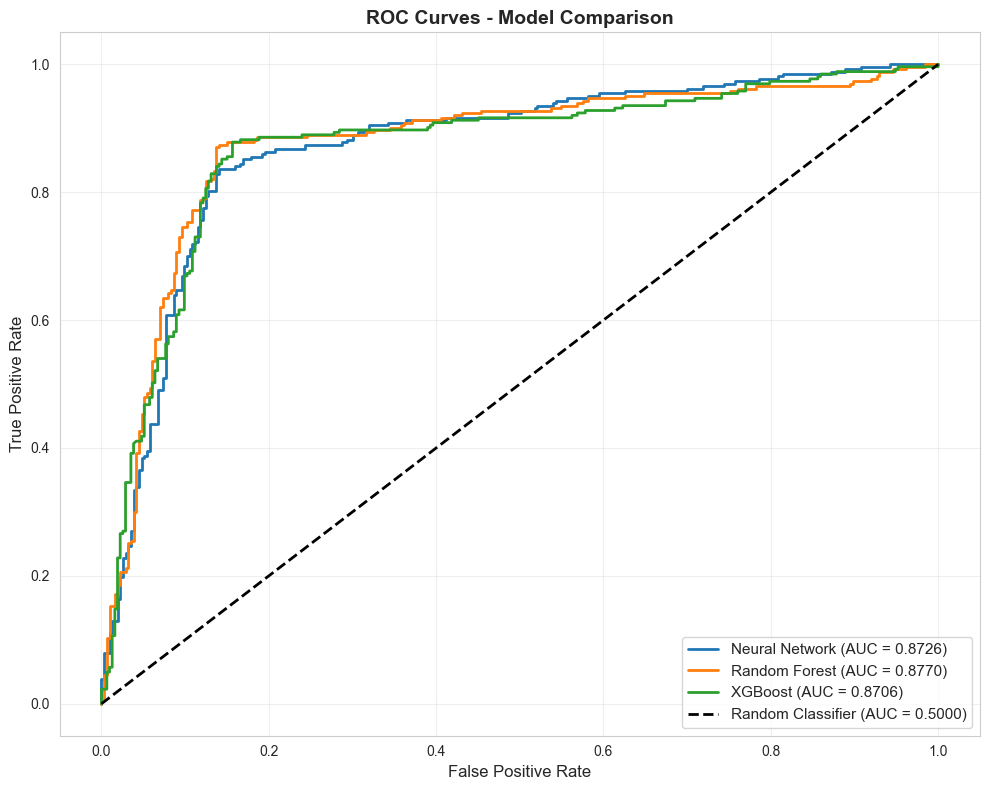


ROC-AUC Interpretation:
  - AUC = 1.0: Perfect classifier
  - AUC = 0.5: Random classifier (no better than coin flip)
  - AUC > 0.7: Generally considered acceptable
  - AUC > 0.8: Excellent performance


In [193]:
# Create ROC curves
fig, ax = plt.subplots(figsize=(10, 8))

models_proba = [
    ('Neural Network', y_pred_proba_nn, nn_roc_auc),
    ('Random Forest', y_pred_proba_rf, rf_roc_auc),
    ('XGBoost', y_pred_proba_xgb, xgb_roc_auc)
]

for name, y_proba, roc_auc in models_proba:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    ax.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.4f})')

# Plot diagonal line (random classifier)
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.5000)')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nROC-AUC Interpretation:")
print("  - AUC = 1.0: Perfect classifier")
print("  - AUC = 0.5: Random classifier (no better than coin flip)")
print("  - AUC > 0.7: Generally considered acceptable")
print("  - AUC > 0.8: Excellent performance")

### Feature Importance Analysis

Analyze which features are most important for predictions.

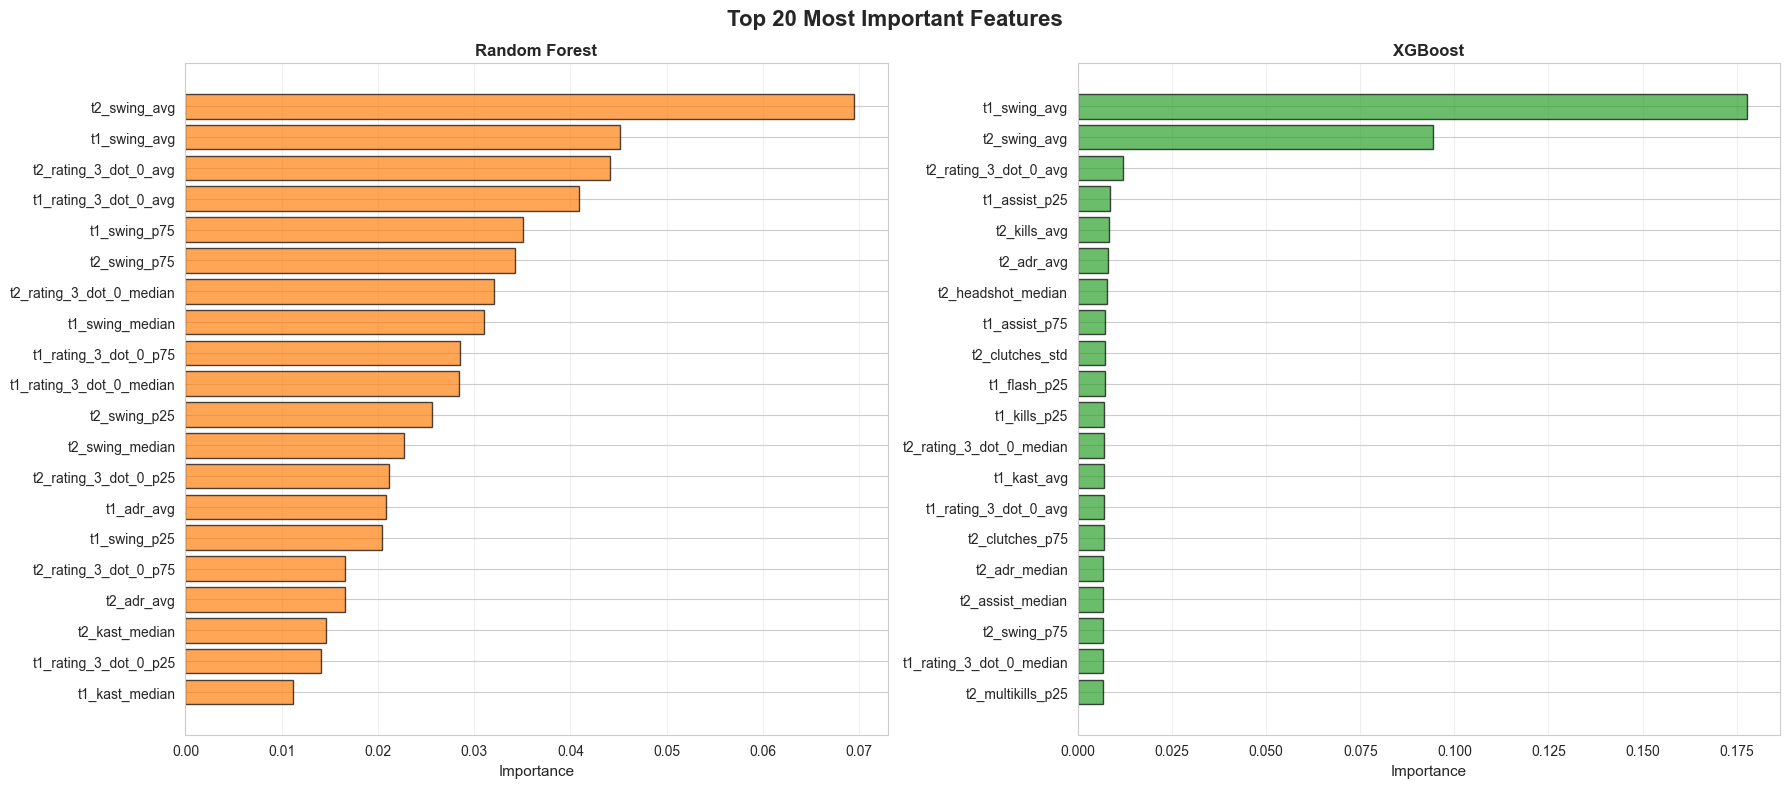


Top 10 Most Important Features (Random Forest):
  t2_swing_avg                             0.069479
  t1_swing_avg                             0.045137
  t2_rating_3_dot_0_avg                    0.044124
  t1_rating_3_dot_0_avg                    0.040880
  t1_swing_p75                             0.035036
  t2_swing_p75                             0.034213
  t2_rating_3_dot_0_median                 0.032102
  t1_swing_median                          0.031054
  t1_rating_3_dot_0_p75                    0.028567
  t1_rating_3_dot_0_median                 0.028425

Top 10 Most Important Features (XGBoost):
  t1_swing_avg                             0.177640
  t2_swing_avg                             0.094378
  t2_rating_3_dot_0_avg                    0.012015
  t1_assist_p25                            0.008631
  t2_kills_avg                             0.008250
  t2_adr_avg                               0.008036
  t2_headshot_median                       0.007802
  t1_assist_p75         

In [194]:
# Feature importance for Random Forest and XGBoost
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Top 20 Most Important Features', fontsize=16, fontweight='bold')

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

ax1 = axes[0]
ax1.barh(range(len(rf_importance)), rf_importance['importance'], color='#ff7f0e', alpha=0.7, edgecolor='black')
ax1.set_yticks(range(len(rf_importance)))
ax1.set_yticklabels(rf_importance['feature'])
ax1.invert_yaxis()
ax1.set_xlabel('Importance', fontsize=11)
ax1.set_title('Random Forest', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

ax2 = axes[1]
ax2.barh(range(len(xgb_importance)), xgb_importance['importance'], color='#2ca02c', alpha=0.7, edgecolor='black')
ax2.set_yticks(range(len(xgb_importance)))
ax2.set_yticklabels(xgb_importance['feature'])
ax2.invert_yaxis()
ax2.set_xlabel('Importance', fontsize=11)
ax2.set_title('XGBoost', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features (Random Forest):")
for idx, row in rf_importance.head(10).iterrows():
    print(f"  {row['feature']:40} {row['importance']:.6f}")

print("\nTop 10 Most Important Features (XGBoost):")
for idx, row in xgb_importance.head(10).iterrows():
    print(f"  {row['feature']:40} {row['importance']:.6f}")

In [195]:
# Detailed classification reports
print("\n" + "=" * 80)
print("DETAILED CLASSIFICATION REPORTS")
print("=" * 80)

print("\n" + "-" * 80)
print("Neural Network")
print("-" * 80)
print(classification_report(y_test, y_pred_nn_test, target_names=['Team 1 Win', 'Team 2 Win']))

print("\n" + "-" * 80)
print("Random Forest")
print("-" * 80)
print(classification_report(y_test, y_pred_rf_test, target_names=['Team 1 Win', 'Team 2 Win']))

print("\n" + "-" * 80)
print("XGBoost")
print("-" * 80)
print(classification_report(y_test, y_pred_xgb_test, target_names=['Team 1 Win', 'Team 2 Win']))


DETAILED CLASSIFICATION REPORTS

--------------------------------------------------------------------------------
Neural Network
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

  Team 1 Win       0.84      0.86      0.85       313
  Team 2 Win       0.83      0.81      0.82       263

    accuracy                           0.84       576
   macro avg       0.84      0.84      0.84       576
weighted avg       0.84      0.84      0.84       576


--------------------------------------------------------------------------------
Random Forest
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

  Team 1 Win       0.89      0.86      0.87       313
  Team 2 Win       0.84      0.87      0.86       263

    accuracy                           0.87       576
   macro avg       0.87      0.87      0.87       576
weighted avg 

### Team-Based Match Prediction

Create a function to predict the winner given two team IDs and a map.

In [196]:
def get_team_stats_for_map(team_id, map_name, team_map_stats_df, player_map_stats_df, map_weight=0.7):
    """
    Get aggregated statistics for a team on a specific map.
    Uses a weighted average: higher weight for map-specific stats, lower for overall stats.
    
    Parameters:
    -----------
    team_id : int
        The team ID
    map_name : str
        The map name (e.g., 'Ancient', 'Dust2')
    team_map_stats_df : polars DataFrame
        The aggregated team statistics per map
    player_map_stats_df : polars DataFrame
        The raw player statistics
    map_weight : float, default=0.7
        Weight for map-specific statistics (0-1). Overall stats get (1 - map_weight).
        Higher values prioritize map-specific performance.
    
    Returns:
    --------
    dict : Dictionary with team statistics
    """
    # Get map_stat_ids for this specific map and team
    map_stat_ids = player_map_stats_df.filter(
        (pl.col('team_id') == team_id) & (pl.col('map_name') == map_name)
    ).select('map_stat_id').unique()['map_stat_id'].to_list()
    
    # Get overall team stats (all maps)
    team_all_stats = team_map_stats_df.filter(pl.col('team_id') == team_id)
    
    if len(team_all_stats) == 0:
        # Team not found at all
        return None
    
    # Calculate overall averages
    overall_stats = {}
    for col in team_all_stats.columns:
        if col not in ['team_id', 'map_stat_id']:
            overall_stats[col] = team_all_stats[col].mean()
    
    # If team has played this specific map, calculate weighted average
    if len(map_stat_ids) > 0:
        team_map_specific = team_map_stats_df.filter(
            (pl.col('team_id') == team_id) & 
            (pl.col('map_stat_id').is_in(map_stat_ids))
        )
        
        if len(team_map_specific) > 0:
            # Calculate map-specific averages
            map_specific_stats = {}
            for col in team_map_specific.columns:
                if col not in ['team_id', 'map_stat_id']:
                    map_specific_stats[col] = team_map_specific[col].mean()
            
            # Weighted average: map_weight * map_stats + (1 - map_weight) * overall_stats
            weighted_stats = {}
            for col in overall_stats.keys():
                if col in map_specific_stats:
                    weighted_stats[col] = (
                        map_weight * map_specific_stats[col] + 
                        (1 - map_weight) * overall_stats[col]
                    )
                else:
                    weighted_stats[col] = overall_stats[col]
            
            return weighted_stats
    
    # If no map-specific stats found, use overall average
    return overall_stats

print("✅ Helper function get_team_stats_for_map() created")

✅ Helper function get_team_stats_for_map() created


In [197]:
def predict_winner_by_teams(team1_id, team2_id, map_name, model, model_name="Model",
                           team_map_stats_df=None, player_map_stats_df=None,
                           scaler=None, feature_columns=None, map_to_encoding=None,
                           map_weight=0.55):
    """
    Predict which team will win a match on a specific map.
    
    Parameters:
    -----------
    team1_id : int
        First team ID
    team2_id : int
        Second team ID
    map_name : str
        Map name (e.g., 'Ancient', 'Dust2', 'Mirage')
    model : trained model object
        The trained model (Neural Network, Random Forest, or XGBoost)
    model_name : str
        Name of the model for display
    team_map_stats_df : polars DataFrame
        Aggregated team statistics (default: uses global team_map_stats)
    player_map_stats_df : polars DataFrame
        Raw player statistics (default: uses global player_map_stats)
    scaler : StandardScaler
        Fitted scaler for normalization (default: uses global scaler)
    feature_columns : list
        List of feature column names (default: uses global feature_columns)
    map_to_encoding : dict
        Map name to encoding dictionary (default: uses global map_to_encoding)
    map_weight : float, default=0.7
        Weight for map-specific statistics (0-1). Higher values prioritize map-specific performance.
        0.7 means 70% weight on map-specific stats, 30% on overall stats.
    
    Returns:
    --------
    prediction : int
        0 for Team 1 win, 1 for Team 2 win
    probabilities : tuple
        (team1_win_prob, team2_win_prob)
    """
    # Use global variables if not provided
    if team_map_stats_df is None:
        team_map_stats_df = team_map_stats
    if player_map_stats_df is None:
        player_map_stats_df = player_map_stats
    if scaler is None:
        scaler = globals()['scaler']
    if feature_columns is None:
        feature_columns = globals()['feature_columns']
    if map_to_encoding is None:
        map_to_encoding = globals()['map_to_encoding']
    
    # Check if map exists
    if map_name not in map_to_encoding:
        available_maps = list(map_to_encoding.keys())
        raise ValueError(f"Map '{map_name}' not found. Available maps: {available_maps}")
    
    # Get team statistics
    team1_stats = get_team_stats_for_map(team1_id, map_name, team_map_stats_df, player_map_stats_df, map_weight)
    team2_stats = get_team_stats_for_map(team2_id, map_name, team_map_stats_df, player_map_stats_df, map_weight)
    
    if team1_stats is None:
        raise ValueError(f"No statistics found for team_id={team1_id}")
    if team2_stats is None:
        raise ValueError(f"No statistics found for team_id={team2_id}")
    
    # Build feature vector
    features = {}
    
    # Add team 1 stats with t1_ prefix
    for key, value in team1_stats.items():
        features[f't1_{key}'] = value
    
    # Add team 2 stats with t2_ prefix
    for key, value in team2_stats.items():
        features[f't2_{key}'] = value
    
    # Add map encoding
    features['map_encoding'] = map_to_encoding[map_name]
    
    # Create feature vector in correct order
    feature_vector = []
    for col in feature_columns:
        if col in features:
            feature_vector.append(features[col])
        else:
            # If feature is missing, use 0 (shouldn't happen with proper data)
            feature_vector.append(0)
    
    # Convert to numpy array and reshape
    feature_vector = np.array(feature_vector).reshape(1, -1)
    
    # Normalize features (excluding map_encoding and IDs if they're in the features)
    # We need to normalize only the statistical features, not metadata
    feature_df = pd.DataFrame(feature_vector, columns=feature_columns)
    
    # Identify which columns to normalize (same as during training)
    columns_to_normalize = [col for col in feature_columns if col not in ['map_encoding']]
    
    # Normalize
    feature_df[columns_to_normalize] = scaler.transform(feature_df[columns_to_normalize])
    
    # Make prediction
    prediction = model.predict(feature_df)[0]
    probabilities = model.predict_proba(feature_df)[0]
    
    # Display results
    print("\n" + "="*80)
    print(f"MATCH PREDICTION: Team {team1_id} vs Team {team2_id} on {map_name}")
    print("="*80)
    print(f"\nModel: {model_name}")
    print(f"Map: {map_name} (encoding: {map_to_encoding[map_name]})")
    print(f"Map-specific weight: {map_weight*100:.0f}% (Overall stats: {(1-map_weight)*100:.0f}%)")
    print(f"\n{'='*80}")
    print(f"🏆 PREDICTED WINNER: Team {team1_id if prediction == 0 else team2_id}")
    print(f"{'='*80}")
    print(f"\nPrediction Probabilities:")
    print(f"  Team {team1_id} Win: {probabilities[0]*100:.2f}%")
    print(f"  Team {team2_id} Win: {probabilities[1]*100:.2f}%")
    print(f"\nConfidence: {max(probabilities)*100:.2f}%")
    print("="*80)
    
    return prediction, probabilities

print("✅ Main prediction function predict_winner_by_teams() created")

✅ Main prediction function predict_winner_by_teams() created


In [198]:
# Example: Predict a match between two teams
# Let's get some team IDs from our data

available_teams = team_map_stats.select('team_id').unique().sort('team_id')['team_id'].to_list()
print(f"Available teams (total: {len(available_teams)}):")
print(f"Team IDs: {available_teams[:20]}...")  # Show first 20

available_maps = list(map_to_encoding.keys())
print(f"\nAvailable maps: {available_maps}")

Available teams (total: 342):
Team IDs: [3044, 4411, 4494, 4548, 4602, 4608, 4773, 4863, 4869, 4903, 4914, 4991, 5378, 5479, 5973, 5995, 6033, 6248, 6626, 6665]...

Available maps: ['Ancient', 'Dust2', 'Inferno', 'Mirage', 'Nuke', 'Overpass', 'Train']


In [ ]:
# Example 1: Predict a match using the first two available teams
if len(available_teams) >= 2:
    example_team1 = available_teams[0]
    example_team2 = available_teams[1]
    example_map = available_maps[0]
    
    print(f"\n{'='*80}")
    print("EXAMPLE PREDICTION 1")
    print(f"{'='*80}")
    
    try:
        # Predict using all three models
        print("\n" + "-"*80)
        print("Neural Network Prediction:")
        print("-"*80)
        nn_pred, nn_proba = predict_winner_by_teams(
            example_team1, example_team2, example_map,
            nn_model, "Neural Network"
        )
        
        print("\n" + "-"*80)
        print("Random Forest Prediction:")
        print("-"*80)
        rf_pred, rf_proba = predict_winner_by_teams(
            example_team1, example_team2, example_map,
            rf_model, "Random Forest"
        )
        
        print("\n" + "-"*80)
        print("XGBoost Prediction:")
        print("-"*80)
        xgb_pred, xgb_proba = predict_winner_by_teams(
            example_team1, example_team2, example_map,
            xgb_model, "XGBoost"
        )
        
        # Show consensus
        print("\n" + "="*80)
        print("MODEL CONSENSUS")
        print("="*80)
        predictions = [nn_pred, rf_pred, xgb_pred]
        winner_team = example_team1 if predictions.count(0) > 1 else example_team2
        agreement = predictions.count(predictions[0]) / len(predictions) * 100
        print(f"\nAll models agree: {'✅ YES' if agreement == 100 else '⚠️ NO'}")
        print(f"Agreement rate: {agreement:.0f}%")
        print(f"Consensus winner: Team {winner_team}")
        print("="*80)
        
    except Exception as e:
        print(f"Error making prediction: {e}")
else:
    print("Not enough teams in dataset for example prediction")


EXAMPLE PREDICTION 1

--------------------------------------------------------------------------------
Neural Network Prediction:
--------------------------------------------------------------------------------
Error making prediction: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- map_encoding



### Quick Prediction Function

A simplified function that uses the best performing model automatically.

In [ ]:
def quick_predict(team1_id, team2_id, map_name, map_weight=0.7):
    """
    Quick prediction using the best performing model.
    
    Parameters:
    -----------
    team1_id : int
        First team ID
    team2_id : int
        Second team ID  
    map_name : str
        Map name (e.g., 'Ancient', 'Dust2', 'Mirage')
    map_weight : float, default=0.7
        Weight for map-specific statistics (0-1). Higher values prioritize map-specific performance.
    
    Returns:
    --------
    winner_id : int
        The predicted winning team ID
    confidence : float
        Prediction confidence (0-100%)
    """
    # Use the best model based on test accuracy
    best_model_idx = comparison_df['Test Accuracy'].idxmax()
    best_model_name = comparison_df.loc[best_model_idx, 'Model']
    
    if best_model_name == 'Neural Network':
        model = nn_model
    elif best_model_name == 'Random Forest':
        model = rf_model
    else:
        model = xgb_model
    
    prediction, probabilities = predict_winner_by_teams(
        team1_id, team2_id, map_name,
        model, best_model_name,
        map_weight=map_weight
    )
    
    winner_id = team1_id if prediction == 0 else team2_id
    confidence = max(probabilities) * 100
    
    return winner_id, confidence

print("✅ Quick prediction function quick_predict() created")
print(f"   Using best model: {comparison_df.loc[comparison_df['Test Accuracy'].idxmax(), 'Model']}")

✅ Quick prediction function quick_predict() created
   Using best model: Random Forest


In [201]:
# Example usage of quick_predict
if len(available_teams) >= 2:
    print("\n" + "="*80)
    print("QUICK PREDICT EXAMPLE")
    print("="*80)
    
    team1 = available_teams[0]
    team2 = available_teams[1]
    map_choice = available_maps[0]
    
    winner, conf = quick_predict(team1, team2, map_choice)
    
    print(f"\n📌 QUICK SUMMARY:")
    print(f"   Winner: Team {winner}")
    print(f"   Confidence: {conf:.1f}%")


QUICK PREDICT EXAMPLE


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- map_encoding


### Understanding Map Weight Parameter

The `map_weight` parameter controls how much to prioritize map-specific performance:

- **map_weight = 1.0**: Use ONLY statistics from the specific map (ignores overall performance)
- **map_weight = 0.7** (default): 70% weight on map-specific stats, 30% on overall stats
- **map_weight = 0.5**: Equal weight between map-specific and overall stats
- **map_weight = 0.0**: Use ONLY overall statistics (ignores map-specific performance)

**Why use weighted averaging?**
- Teams that have played a map many times → map-specific stats are more reliable
- Teams new to a map or with limited games → overall stats provide stability
- Weighted approach balances both, reducing variance while capturing map expertise

In [ ]:
# Compare predictions with different map weights
if len(available_teams) >= 2:
    print("\n" + "="*80)
    print("MAP WEIGHT COMPARISON - How weighting affects predictions")
    print("="*80)
    
    team1 = available_teams[0]
    team2 = available_teams[1]
    map_choice = available_maps[0]
    
    # Test different weights
    weights_to_test = [0.0, 0.3, 0.5, 0.7, 0.9, 1.0]
    
    print(f"\nMatchup: Team {team1} vs Team {team2}")
    print(f"Map: {map_choice}")
    print(f"Model: {comparison_df.loc[comparison_df['Test Accuracy'].idxmax(), 'Model']}")
    print("\n" + "-"*80)
    
    results = []
    for weight in weights_to_test:
        try:
            winner, conf = quick_predict(team1, team2, map_choice, map_weight=weight)
            results.append({
                'Map Weight': f"{weight*100:.0f}%",
                'Overall Weight': f"{(1-weight)*100:.0f}%",
                'Predicted Winner': f"Team {winner}",
                'Confidence': f"{conf:.1f}%"
            })
        except Exception as e:
            results.append({
                'Map Weight': f"{weight*100:.0f}%",
                'Overall Weight': f"{(1-weight)*100:.0f}%",
                'Predicted Winner': 'Error',
                'Confidence': str(e)
            })
    
    # Display as dataframe
    results_df = pd.DataFrame(results)
    print("\n" + results_df.to_string(index=False))
    print("\n" + "="*80)
    
    print("\n💡 Insights:")
    print("  - Higher map weight → More emphasis on how teams perform on this specific map")
    print("  - Lower map weight → More emphasis on overall team strength across all maps")
    print("  - Default (70%) provides a good balance for most predictions")
else:
    print("Not enough teams for comparison")


MAP WEIGHT COMPARISON - How weighting affects predictions

Matchup: Team 3044 vs Team 4411
Map: Ancient
Model: Random Forest

--------------------------------------------------------------------------------

MATCH PREDICTION: Team 3044 vs Team 4411 on Ancient

Model: Random Forest
Map: Ancient (encoding: 0)
Map-specific weight: 0% (Overall stats: 100%)

🏆 PREDICTED WINNER: Team 4411

Prediction Probabilities:
  Team 3044 Win: 8.53%
  Team 4411 Win: 91.47%

Confidence: 91.47%

MATCH PREDICTION: Team 3044 vs Team 4411 on Ancient

Model: Random Forest
Map: Ancient (encoding: 0)
Map-specific weight: 30% (Overall stats: 70%)

🏆 PREDICTED WINNER: Team 4411

Prediction Probabilities:
  Team 3044 Win: 44.04%
  Team 4411 Win: 55.96%

Confidence: 55.96%

MATCH PREDICTION: Team 3044 vs Team 4411 on Ancient

Model: Random Forest
Map: Ancient (encoding: 0)
Map-specific weight: 50% (Overall stats: 50%)

🏆 PREDICTED WINNER: Team 3044

Prediction Probabilities:
  Team 3044 Win: 53.98%
  Team 4411 Win

---

## 🎯 Prediction API Summary

### Complete Function Reference

#### 1. **`predict_winner_by_teams()`** - Full Control
```python
prediction, probabilities = predict_winner_by_teams(
    team1_id=123,
    team2_id=456,
    map_name='Mirage',
    model=xgb_model,
    model_name='XGBoost',
    map_weight=0.7  # Optional: 0.0 to 1.0, default 0.7
)
```
- Returns: `(prediction, probabilities)`
- Displays detailed prediction results
- Allows custom model selection
- Configurable map-specific weighting

#### 2. **`quick_predict()`** - Simple Interface
```python
winner_id, confidence = quick_predict(
    team1_id=123,
    team2_id=456,
    map_name='Mirage',
    map_weight=0.7  # Optional: default 0.7
)
```
- Returns: `(winner_id, confidence_percentage)`
- Automatically uses best performing model
- Less verbose output
- Perfect for batch predictions

### Map Weight Guidelines

| Scenario | Recommended Weight | Reasoning |
|----------|-------------------|------------|
| Teams with extensive map history | 0.8 - 1.0 | Trust map-specific performance |
| Standard prediction (default) | 0.7 | Balanced approach |
| Teams new to the map | 0.3 - 0.5 | Rely more on overall skill |
| Map stats unavailable | 0.0 | Fall back to overall performance |

### Available Data
```python
# Get available teams
available_teams = team_map_stats.select('team_id').unique()['team_id'].to_list()

# Get available maps
available_maps = list(map_to_encoding.keys())
```